# notebook for imputations of IBEX data from single cell RNA and CiteSeq

In [1]:
import os
#import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
anno = 'anno_CITE'

In [22]:
source_folder = ''

In [3]:
ibex = sc.read("") # load most recent IBEX object 
gex = sc.read("") # load most recent atlas object 

# Step 0 - objects cleanup

## Cleanup gex 

In [4]:
# update other cells from non T cells 
gex.obs[anno] = gex.obs.apply(lambda 
                              x: np.nan if x['age_group'] == 'fetal' else
                                           x['cell_type_level_4_explore'] if x['anno_CITE'] == 'B' else 
                                           x['cell_type_level_4_explore'] if x['anno_CITE'] == 'DC' else 
                                           x['anno_CITE'] if x['study'] == 'HTSA_Ghent' else
                                           x['cell_type_level_4_explore'] if x['cell_type_level_0'] not in ['T_DN', 'T_DP', 'T_SP'] else
                              np.nan, axis = 1)
gex = gex[~gex.obs[anno].isna()]
gex = gex[gex.obs[anno] != 'nan']
gex = gex[gex.obs[anno] != 'unknown']
gex.obs[anno] = gex.obs[anno].astype('category')


prolif_cells = ['DC1-Prolif', 'DC2-Prolif', 'pDC-Prolif', 'PeriloFb-Prolif', 'ProlifPericyte','mcTEC-Prolif',
               'B-Prolif']
fet_specific = ['pro_B', 'late_pro_B', 'large_pre_B', 'small_pre_B', 'CMP', 'GMP', 'InterloFb-COL9A3',
                'fetFB-NKX2-5', 'fetFB-CCL21','fetFB-RSPO2', 'Mesothelium', 'mcTEC-Prolif',
               'T_NK_fetal', ]
unclear = ['T_DP(Q)-HSPH1','T_SP8or4','T_SP-HSP','T_DN(Q)-stress_1','T_DN(Q)-stress_2','T_DN(Q)-intermediate','T_Treg-intermediate']
to_remove = set(gex.obs[anno].value_counts().loc[gex.obs[anno].
                                                                      value_counts()<=40].index.tolist()+
            prolif_cells + fet_specific + unclear)

gex = gex[~gex.obs[anno].isin(to_remove),:].copy()
# take cells from each sample 
def subset_by_anno(adata, cluster_key , target_cells=20000):
    adatas = [adata[adata.obs[cluster_key] == clust].copy() for clust in adata.obs[cluster_key].cat.categories]
    for dat in adatas:
        if dat.n_obs > target_cells:
            sc.pp.subsample(dat, n_obs=target_cells)
    adata_sub = adatas[0].concatenate(*adatas[1:])
    return adata_sub

gex = subset_by_anno(gex, anno,target_cells=10000)

/tmp/ipykernel_20002/3508703591.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gex.obs[anno] = gex.obs[anno].astype('category')


In [5]:
# see cell proportions
anno = 'anno_CITE'
for i, j in gex.obs[anno].value_counts().items():
    print(str(i) + ' ' + str(j))
    

DP(Q)_rearr 10000
DP(P) 10000
DP_4hi8lo 10000
committed_CD4pos 6050
DP_pos_sel 4874
SP_CD4_semimature 4661
DP(Q) 4349
SP_CD4_immature 4197
SP_CD8_semimature 3927
mcTEC 3117
committed_CD4neg 3002
mTECI 2879
DP_early_CD31 2542
T_DP(Q)-CD99 2507
SP_Treg_mature 2307
T_DP(Q)-late_vdj 2188
cTECIII 2152
cTECI 1994
SP_Treg_immature 1895
cTECII 1615
SMC 1564
EC-Ven 1539
SP_CD8_immature 1514
B-memory 1357
PeriloFb 1317
TEC-neuro 1230
InterloFb 1227
committed_CD4neg(P) 1184
B-naive 991
EC-Cap 864
CD8aaI_mature 834
mTECII 775
SP_CD4_mature 775
CD8aaI_immature 753
mTECIII 747
EC-Art 721
CD8aaII_immature 640
committed_CD4pos(P) 561
medFb-RGS5 551
CD8aaII_mature 532
SP_Treg_CD8 508
TEC-myo 507
TEC-cilliated 480
SP_CD8_mature 378
medFB-MHCIIh 357
Pericyte 335
mTECI-trans 331
SP_Treg_PD1 312
gdT_semimature 303
pDC 295
DC1 274
aDC3 273
gdT_mature 202
gdT_immature 195
NK_tr_itg_hi 191
medFb 179
SP_CD8_memory 176
Pericyte_CCL19 172
uncommitted 165
SP_Treg_recirc 133
EC-Art-ELN 129
EC-Lymphatic 128
aDC2 12

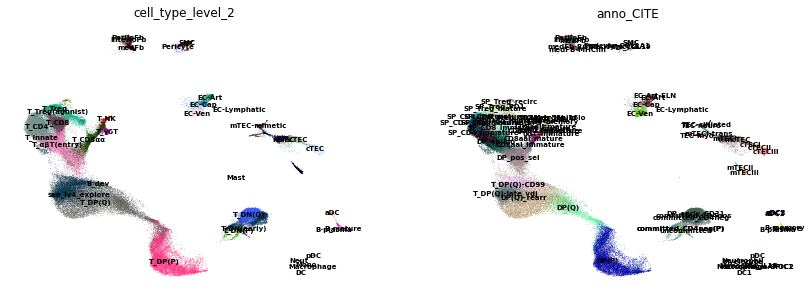

In [6]:
sc.pl.umap(gex, color = ['cell_type_level_2', 'anno_CITE'], legend_loc = "on data", 
          legend_fontsize = 7, frameon = False)

In [7]:
# gex

## Pre process IBEX

In [8]:
ibex = subset_by_anno(ibex, 'sample' , target_cells=100000)
ibex

AnnData object with n_obs × n_vars = 764448 × 45
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch'
    layers: 'counts'

In [9]:
# translate the protein marker name to it's corresponding gene in the gex data  
protein_to_gene = {
    'nuclear_mean': None,
    'CHGA_mean': 'CHGA',
    'CD99_mean': 'CD99',
    'CD163_mean': 'CD163',
    'CD11C_mean': 'ITGAX',
    'CD8_mean': 'CD8A',
    'CD3_mean': 'CD3D',
    'CD5_mean': 'CD5',
    'CD20_mean': 'MS4A1',
    'CD34_mean': 'CD34',
    'CD7_mean': 'CD7',
    'CD31_mean': 'PECAM1',
    'CD39_mean': 'ENTPD1',
    'CD4_mean': 'CD4',
    'VA7.2_mean': 'TRAV7',
    'TUBB3_mean': 'TUBB3',
    'CD206_mean': 'MRC1',
    'SPARC_mean': 'SPARC',
    'LAMIN_A_mean': 'LMNA',
    'HLADR_mean': 'HLA-DRB1',
    'CD123_mean': 'IL3RA',
    'DEC205_mean': 'LY75',
    'AQP1_mean': 'AQP1',
    'KI67_mean': 'MKI67',
    'AIRE_mean': 'AIRE',
    'CD49A_mean': 'ITGA1',
    'KERATIN_10_mean': 'KRT10',
    'KERATIN_15_mean': 'KRT15',
    'LUMICAN_mean': 'LUM',
    'LYVE1_mean': 'LYVE1',
    'VIMENTIN_mean': 'VIM',
    'KERATIN_14_mean': 'KRT14',
    'ANNEXIN1_mean': 'ANXA1',
    'CD15_mean': 'FUT4',
    'CD45_mean': 'PTPRC',
    'SYP_mean': 'SYP',
    'TCRGD_mean': 'TCRG',
    'KERATIN_8_mean': 'KRT8',
    'PANCYTO_mean': None,
    'ASMA_mean': 'ACTA2',
    'KERATIN_5_mean': 'KRT5',
    'FOXP3_mean': 'FOXP3',
    'DESMIN_mean': 'DES',
    'CD49F_mean': 'ITGA6',
    'CD15_0_mean': None
}

# Create a new column in anndata.var for protein names
ibex.var['gene_name'] = ''
ibex.var['protein_name'] = ''

# Iterate over each row in anndata.var and map protein names to gene names
for idx, row in ibex.var.iterrows():
    protein_name = row.name
    if protein_name in protein_to_gene:
        gene_name = protein_to_gene[protein_name]
        ibex.var.loc[idx, 'gene_name'] = gene_name
        ibex.var.loc[idx, 'protein_name'] = protein_name

# Print the updated anndata.var DataFrame
print(ibex.var)

                gene_name     protein_name
nuclear_mean         None     nuclear_mean
CHGA_mean            CHGA        CHGA_mean
CD99_mean            CD99        CD99_mean
CD163_mean          CD163       CD163_mean
CD11C_mean          ITGAX       CD11C_mean
CD8_mean             CD8A         CD8_mean
CD3_mean             CD3D         CD3_mean
CD5_mean              CD5         CD5_mean
CD20_mean           MS4A1        CD20_mean
CD34_mean            CD34        CD34_mean
CD7_mean              CD7         CD7_mean
CD31_mean          PECAM1        CD31_mean
CD39_mean          ENTPD1        CD39_mean
CD4_mean              CD4         CD4_mean
VA7.2_mean          TRAV7       VA7.2_mean
TUBB3_mean          TUBB3       TUBB3_mean
CD206_mean           MRC1       CD206_mean
SPARC_mean          SPARC       SPARC_mean
LAMIN_A_mean         LMNA     LAMIN_A_mean
HLADR_mean       HLA-DRB1       HLADR_mean
CD123_mean          IL3RA       CD123_mean
DEC205_mean          LY75      DEC205_mean
AQP1_mean  

In [10]:
# Filter out non-gene features and update var_names
gene_features = []
new_var_names = []
for feature in ibex.var_names:
    if feature in protein_to_gene and protein_to_gene[feature] is not None:
        gene_features.append(feature)
        new_var_names.append(protein_to_gene[feature])

# Create a new AnnData object with gene features
ibex_gene = ibex[:, gene_features].copy()

# Update var_names in the new AnnData object
ibex_gene.var_names = new_var_names

# Print the new AnnData object
ibex_gene.var_names


Index(['CHGA', 'CD99', 'CD163', 'ITGAX', 'CD8A', 'CD3D', 'CD5', 'MS4A1',
       'CD34', 'CD7', 'PECAM1', 'ENTPD1', 'CD4', 'TRAV7', 'TUBB3', 'MRC1',
       'SPARC', 'LMNA', 'HLA-DRB1', 'IL3RA', 'LY75', 'AQP1', 'MKI67', 'AIRE',
       'ITGA1', 'KRT10', 'KRT15', 'LUM', 'LYVE1', 'VIM', 'KRT14', 'ANXA1',
       'FUT4', 'PTPRC', 'SYP', 'TCRG', 'KRT8', 'ACTA2', 'KRT5', 'FOXP3', 'DES',
       'ITGA6'],
      dtype='object')

In [11]:
# filter and batch correct ibex data 
ibex_gene = ibex_gene[ibex_gene.obs['manual_bin_cma_v2'].dropna().index]
ibex_gene.X = np.nan_to_num(ibex_gene.X, nan=0)
sc.pp.combat(ibex_gene, key='sample', inplace=True) # batch correct 
ibex_gene.X = np.nan_to_num(ibex_gene.X, nan=0)


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


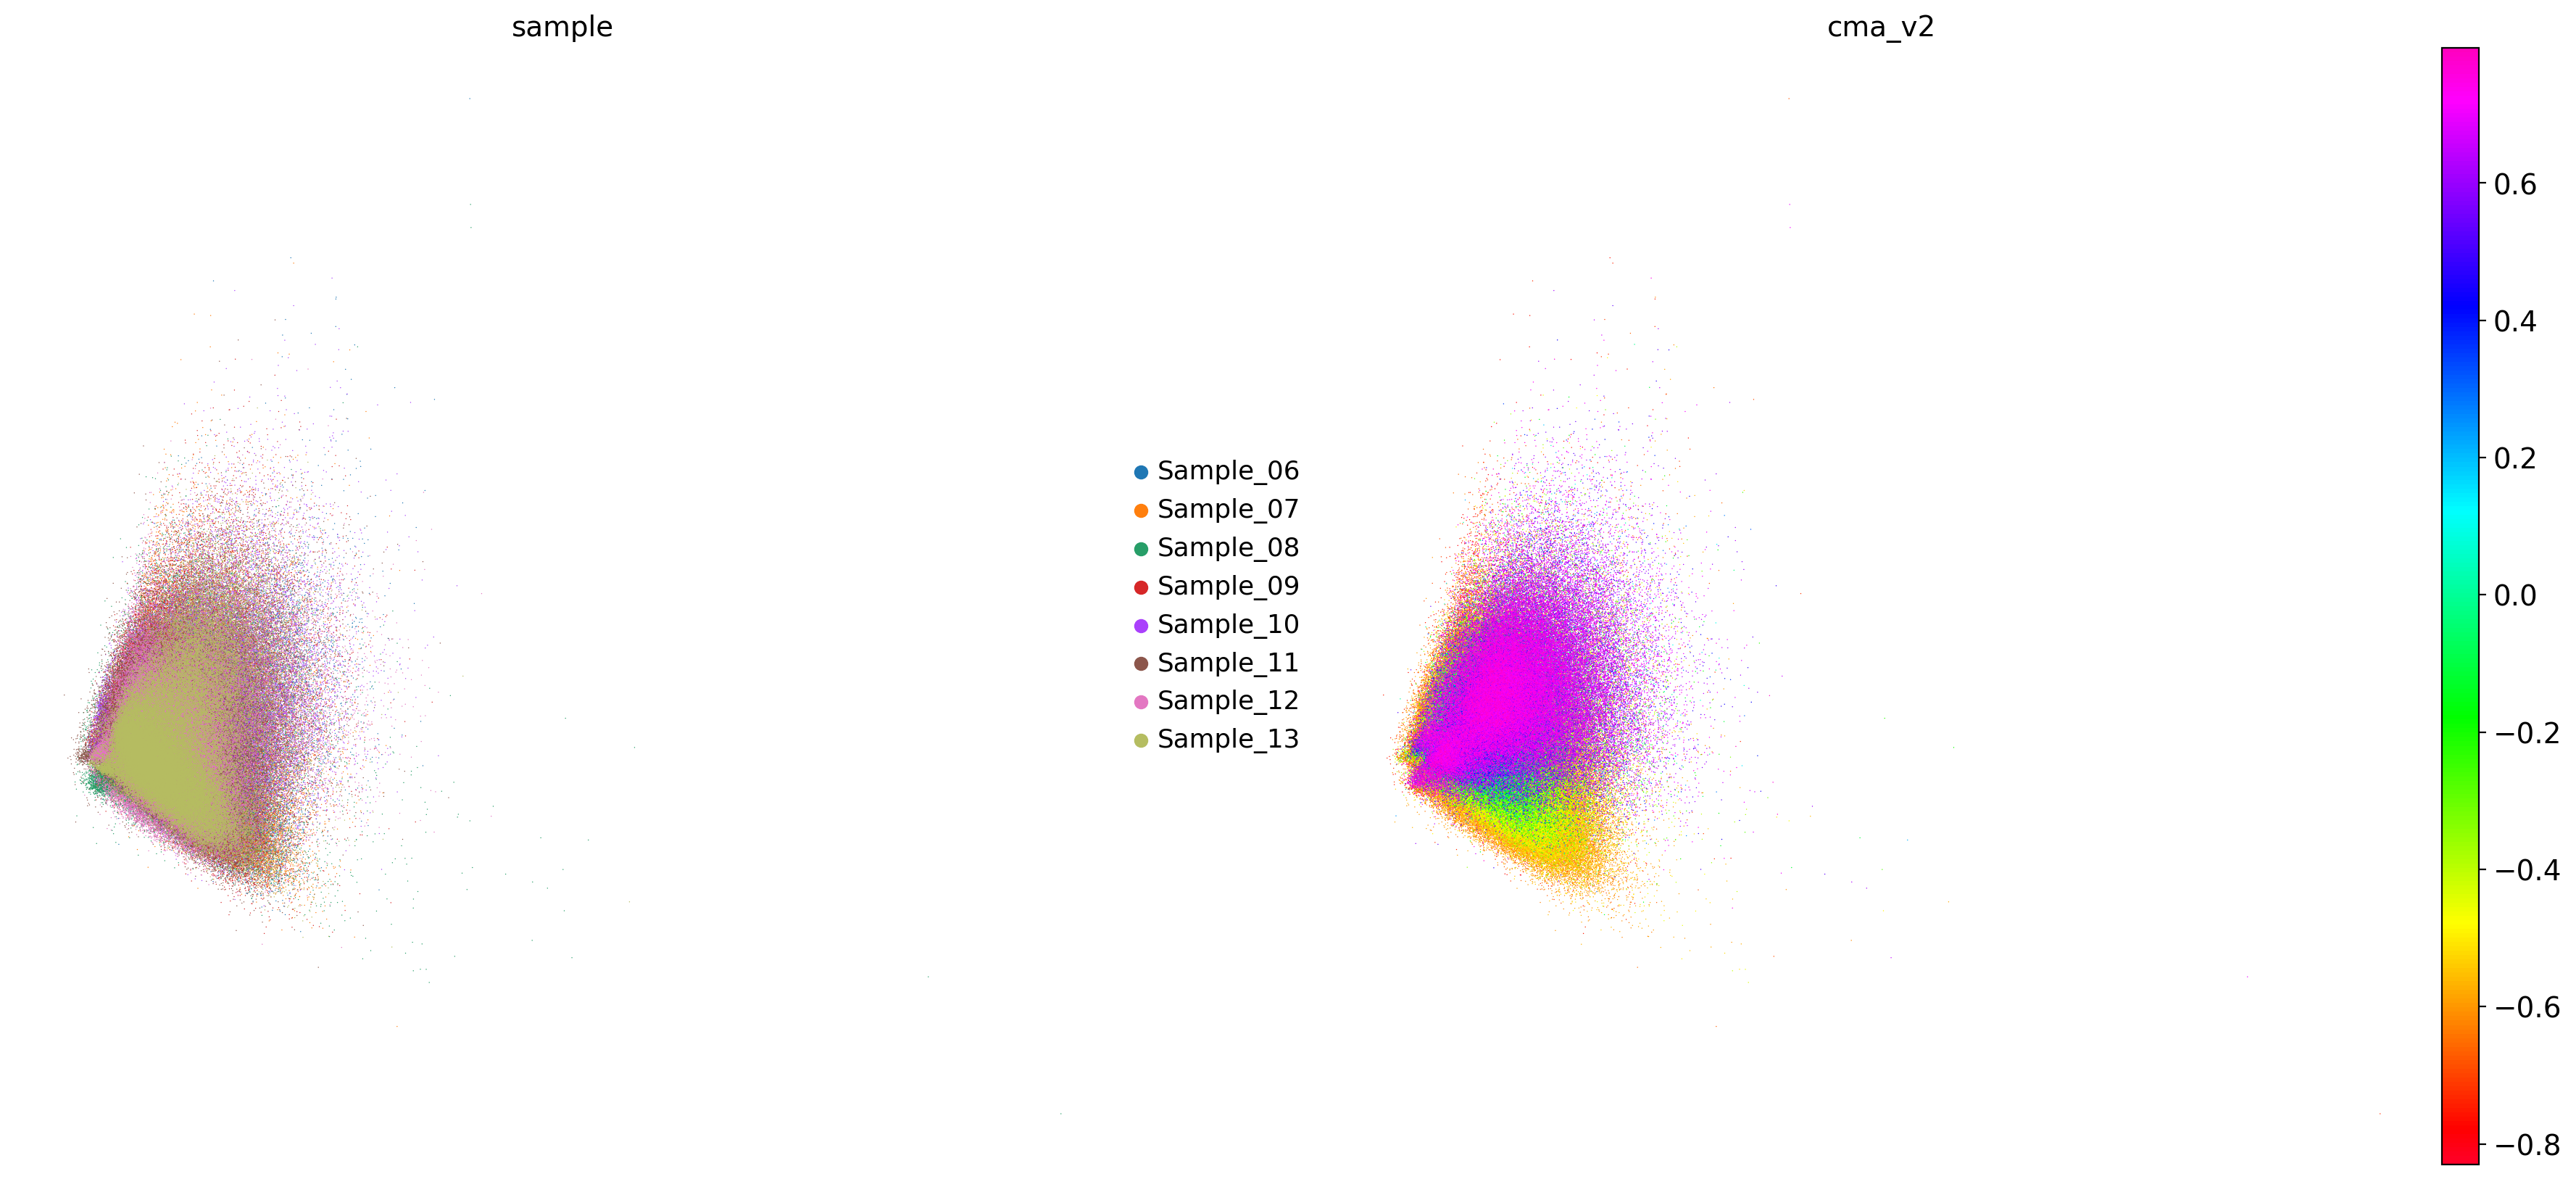

,protein_name
gene_name,
CHGA,CHGA_mean
CD99,CD99_mean
CD163,CD163_mean
ITGAX,CD11C_mean
CD8A,CD8_mean
CD3D,CD3_mean
CD5,CD5_mean
MS4A1,CD20_mean
CD34,CD34_mean


In [12]:
# plot PCA for sanity 
sc.pp.pca(ibex_gene, n_comps = 10)
sc.set_figure_params(figsize=[10,10],dpi=100)
sc.pl.pca(ibex_gene,color=['sample','cma_v2'],cmap='gist_rainbow',frameon=False,s=1)
ibex_gene.var['gene_name'] = ibex_gene.var['gene_name'].astype(str)
ibex_gene.var = ibex_gene.var.set_index("gene_name")
ibex_gene.var

In [13]:
# check how many genes are overlapping 
len(set(ibex_gene.var_names).intersection(gex.var_names))

41

In [14]:
os.chdir('')
gex.write_h5ad('pre_patcher_gex.h5ad')
ibex_gene.write_h5ad('pre_patcher_ibex.h5ad')
ibex.write_h5ad('pre_patcher_ibex_raw.h5ad')

# end of preprocessing 

# Step 1- Run patcher on all cells 

In [3]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 

In [4]:
os.chdir('')

In [5]:
gex = sc.read_h5ad('pre_patcher_gex.h5ad')
ibex_gene = sc.read_h5ad('pre_patcher_ibex.h5ad')

In [6]:
ibex_gene

AnnData object with n_obs × n_vars = 764448 × 42
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch'
    var: 'protein_name'
    uns: 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [11]:
anno = 'anno_CITE'
# run pisser on individual samples without batch correctino 
import time
import scanpy as sc

In [16]:
# Get unique samples
unique_samples = ibex_gene.obs['sample'].unique()

# Dictionary to hold output for each sample
out_dict = {}

# Run the function for each sample and append the result to the list
for sample in unique_samples:
    start_time = time.time()
    # subset sample
    ibex_gene_sample = ibex_gene[ibex_gene.obs['sample'] == sample]
    # scale each sample 
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1000))
    ibex_gene_sample.X = scaler.fit_transform(ibex_gene_sample.X)
    # remove counts smaller than 1 
    # run patcher 
    out_sample = ip.patch(iss=ibex_gene_sample, gex=gex, obs_to_take=anno, computation='cKDTree', neighbours=30,obsm_fraction=True,chunk_size=200000)
    out_dict[sample] = out_sample
    end_time = time.time()
    print(f"Processed sample {sample} in {end_time - start_time} seconds")

# Concatenate all the results
out = sc.concat(out_dict, join='outer')

/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_06 in 132.61137628555298 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_07 in 132.39478945732117 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_08 in 127.48134326934814 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_09 in 135.59146904945374 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_10 in 125.62875962257385 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_11 in 130.52434945106506 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_12 in 126.41728663444519 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_13 in 94.47487378120422 seconds


In [ ]:
out.obs[anno] = out.obs[anno].astype('category')

In [5]:
def plot_cell_dotplot(
    adata,
    x_anno,
    y_anno,
    x_anno_groups,
    y_anno_groups,
    figsize=[4, 4],
    cmap='viridis',
    save_name=None,
):

    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # Group by y_anno and x_anno, then count
    cell_type_counts = adata.obs.groupby([y_anno, x_anno]).size().rename('cell_type_count').reset_index()

    # Calculate sum of counts for each y_anno group
    group_totals = cell_type_counts.groupby(x_anno)['cell_type_count'].transform('sum')

    # Divide each count by the total count of its group to get the proportion
    cell_type_counts['cell_type_frequency'] = cell_type_counts['cell_type_count'] / group_totals

    # Pivot data for dot plot
    pivot_df_cell_type = cell_type_counts.pivot(index=x_anno, columns=y_anno, values='cell_type_frequency')

    # Reorder the clusters
    pivot_df_cell_type = pivot_df_cell_type.reindex(x_anno_groups)
    pivot_df_cell_type = pivot_df_cell_type.reindex(index=x_anno_groups, columns=y_anno_groups)

    # Get the max value for size normalization across the entire dataset
    max_size_value = pivot_df_cell_type.max().max()

    n_x_anno = len(x_anno_groups)
    n_y_anno = len(y_anno_groups)

    fig, ax = plt.subplots(figsize=figsize)

    for j in range(n_y_anno):
        # Normalize color based on the maximum value in each y_anno group
        max_color_value = pivot_df_cell_type.iloc[:, j].max()
        norm_color = mcolors.Normalize(vmin=0, vmax=max_color_value)
        cmap_color = cm.get_cmap(cmap)

        for i in range(n_x_anno):
            x_val = j
            y_val = i
            size = pivot_df_cell_type.iloc[i, j]
            if pd.notna(size):  # Ensure that the value is not NaN
                normalized_size = size / max_size_value
                ax.scatter(x_val, y_val, s=normalized_size * 500, c=[cmap_color(norm_color(size))])

    ax.set_title('Cell Type Normalized Frequencies')
    ax.set_xticks(range(n_y_anno))
    ax.set_yticks(range(n_x_anno))
    ax.set_xticklabels(y_anno_groups, rotation=90) # Rotate the x-labels
    ax.set_yticklabels(x_anno_groups)

    # Add space between the extreme values along the x-axis
    plt.xlim(-1, n_y_anno)

    # Remove grid
    ax.grid(False)

    # Invert the y-axis to display the categories in the desired order
    ax.invert_yaxis()

    plt.tight_layout()

    # Save the figure if save_name is specified
    if save_name:
        plt.savefig(save_name)

    plt.show()

In [42]:
## The same output as plot_cell_dotplot, but allows you to export SourceFiles
def plot_cell_dotplot2(
    adata,
    x_anno,
    y_anno,
    x_anno_groups,
    y_anno_groups,
    figsize=[4, 4],
    cmap='viridis',
    save_name=None,
    export_path=None
):

    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # Group by y_anno and x_anno, then count
    cell_type_counts = adata.obs.groupby([y_anno, x_anno]).size().rename('cell_type_count').reset_index()

    # Calculate sum of counts for each y_anno group
    group_totals = cell_type_counts.groupby(x_anno)['cell_type_count'].transform('sum')

    # Divide each count by the total count of its group to get the proportion
    cell_type_counts['cell_type_frequency'] = cell_type_counts['cell_type_count'] / group_totals

    # Pivot data for dot plot
    pivot_df_cell_type = cell_type_counts.pivot(index=x_anno, columns=y_anno, values='cell_type_frequency')

    # Reorder the clusters
    pivot_df_cell_type = pivot_df_cell_type.reindex(x_anno_groups)
    pivot_df_cell_type = pivot_df_cell_type.reindex(index=x_anno_groups, columns=y_anno_groups)

    # Get the max value for size normalization across the entire dataset
    max_size_value = pivot_df_cell_type.max().max()

    n_x_anno = len(x_anno_groups)
    n_y_anno = len(y_anno_groups)

    fig, ax = plt.subplots(figsize=figsize)
    df_size = pivot_df_cell_type/pivot_df_cell_type.max(axis = None)
    df_color = pivot_df_cell_type/pivot_df_cell_type.max(axis = 0)
    norm_color = mcolors.Normalize(vmin=0, vmax=1)
    cmap_color = cm.get_cmap(cmap)
    for j in range(n_y_anno):
        for i in range(n_x_anno):
            ax.scatter(j, i, s=df_size.iloc[i, j] * 500, 
                       c=[cmap_color(norm_color(df_color.iloc[i, j]))])
    ax.set_title('Cell Type Normalized Frequencies')
    ax.set_xticks(range(n_y_anno))
    ax.set_yticks(range(n_x_anno))
    ax.set_xticklabels(y_anno_groups, rotation=90) # Rotate the x-labels
    ax.set_yticklabels(x_anno_groups)

    # Add space between the extreme values along the x-axis
    plt.xlim(-1, n_y_anno)

    # Remove grid
    ax.grid(False)

    # Invert the y-axis to display the categories in the desired order
    ax.invert_yaxis()

    plt.tight_layout()

    # Save the figure if save_name is specified
    if save_name:
        plt.savefig(save_name)
    
    if export_path:
        df1 = df_size.copy()
        df2 = df_color.copy()
        title1 = pd.DataFrame(['Relative abundance (normalised to all)'], columns=['Title'])
        title2 = pd.DataFrame(['Cell type enrichment (in layer)'], columns=['Title'])
        # Create an Excel writer object
        with pd.ExcelWriter(export_path, engine='openpyxl') as writer:
            # Write the first title
            title1.to_excel(writer, index=False, header=False, startrow=0, sheet_name='Sheet1')
            # Write the first dataframe
            df1.to_excel(writer, startrow=1, sheet_name='Sheet1')
            # Calculate the row to start the second title
            startrow = len(df1) + 3  # Adding 4 rows for spacer and title
            # Write the second title
            title2.to_excel(writer, index=False, header=False, startrow=startrow, sheet_name='Sheet1')
            # Write the second dataframe
            df2.to_excel(writer, startrow=startrow+1, sheet_name='Sheet1')
            print (f'{export_path} has been written')
            
    plt.show()

In [18]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/')
out = sc.read_h5ad('out_RNA_1m_KNN30_v3.h5ad')

In [19]:
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
out.obs = ims.bin_axis(ct_order ,ct2_values,out.obs,'cma_v2')   
out.obs.loc[out.obs['annotation_lv_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
out.obs['manual_bin_cma_v2'] = out.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
out.obs['manual_bin_cma_v2'].value_counts()


Capsular= (-0.75>cma_v2)
Sub-Capsular= (-0.75<=cma_v2) & (-0.62>cma_v2)
Cortical level 1= (-0.62<=cma_v2) & (-0.55>cma_v2)
Cortical level 2= (-0.55<=cma_v2) & (-0.45>cma_v2)
Cortical level 3= (-0.45<=cma_v2) & (-0.3>cma_v2)
Cortical CMJ= (-0.3<=cma_v2) & (0.1>cma_v2)
Medullar CMJ= (0.1<=cma_v2) & (0.55>cma_v2)
Medullar level 1= (0.55<=cma_v2) & (0.65>cma_v2)
Medullar level 2= (0.65<=cma_v2) & (0.7>cma_v2)
Medullar level 3= (0.7=<cma_v2)


manual_bin_cma_v2
Cortical level 1    222524
Cortical level 2    154972
Sub-Capsular        109138
Cortical level 3     70208
Capsular             47818
Cortical CMJ         45049
Medullar CMJ         35639
Medullar level 3     31844
Medullar level 1     27340
Medullar level 2     19916
Name: count, dtype: int64

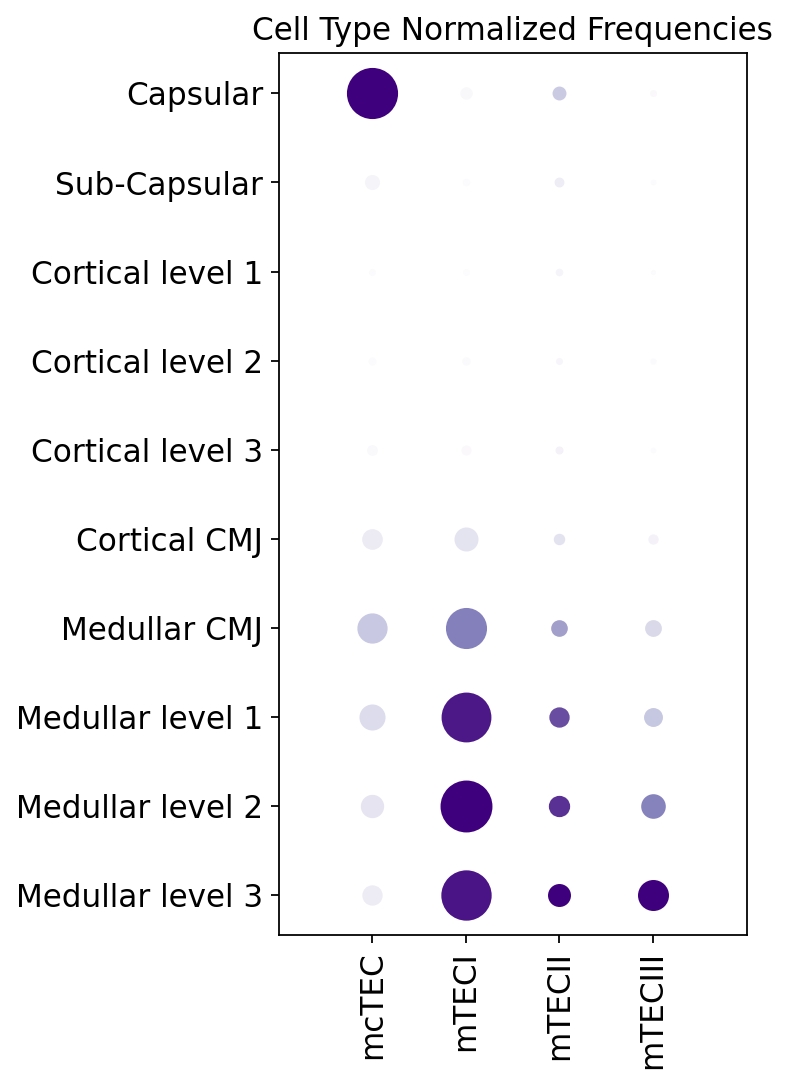

/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/IBEX_paed_0.85_mTEC_dotplot.xlsx has been written


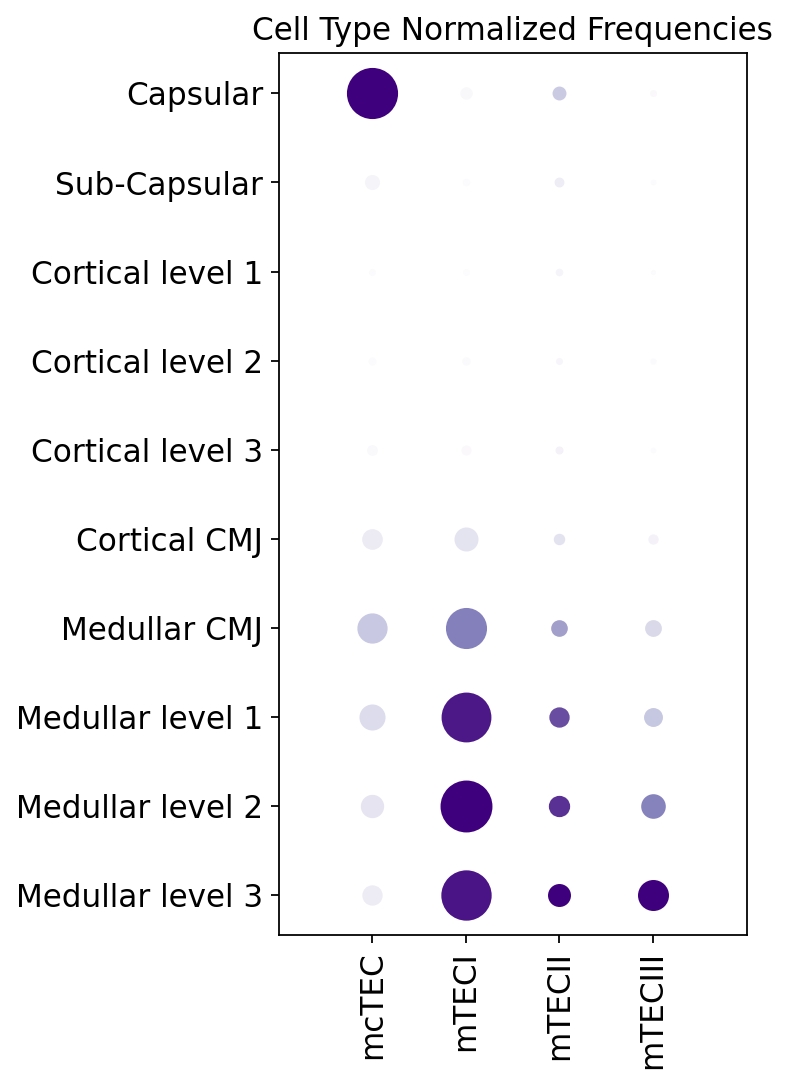

In [43]:
sc.set_figure_params(figsize=[5,5])
cells = ['mcTEC','mTECI','mTECII','mTECIII']
fraction = 0.85
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[5,7],cmap='Purples')
plot_cell_dotplot2(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE',
                         x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,
                         export_path = f'{source_folder}/IBEX_paed_{fraction}_mTEC_dotplot.xlsx', figsize=[5,7],cmap='Purples')

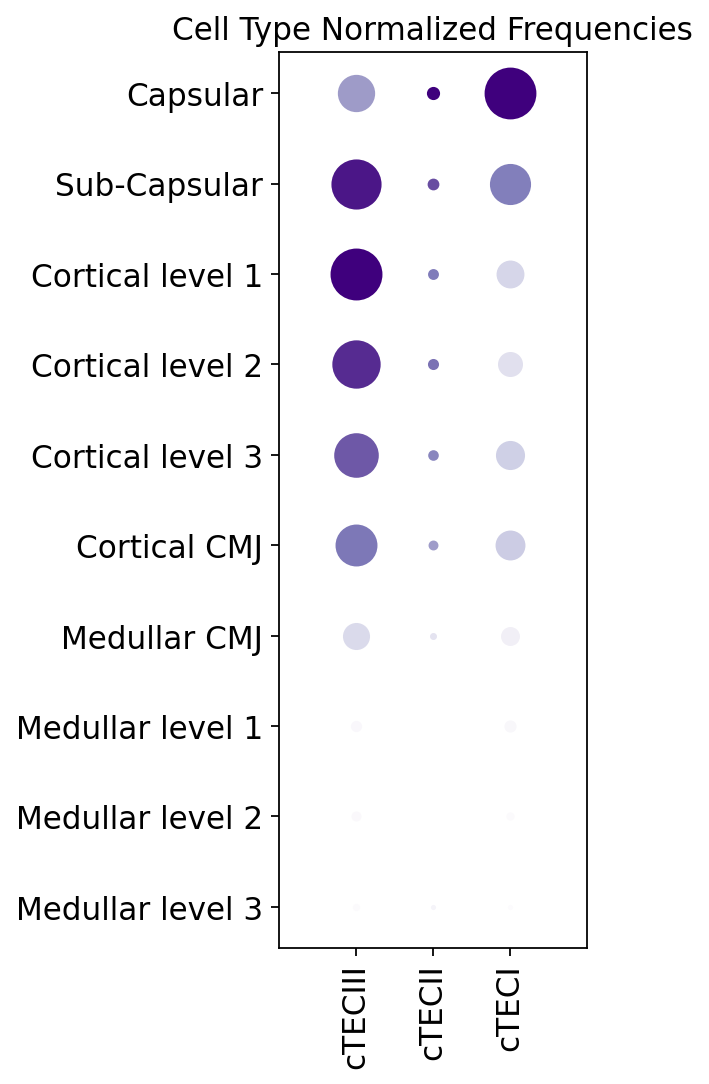

/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/IBEX_paed_0.45_cTEC_dotplot.xlsx has been written


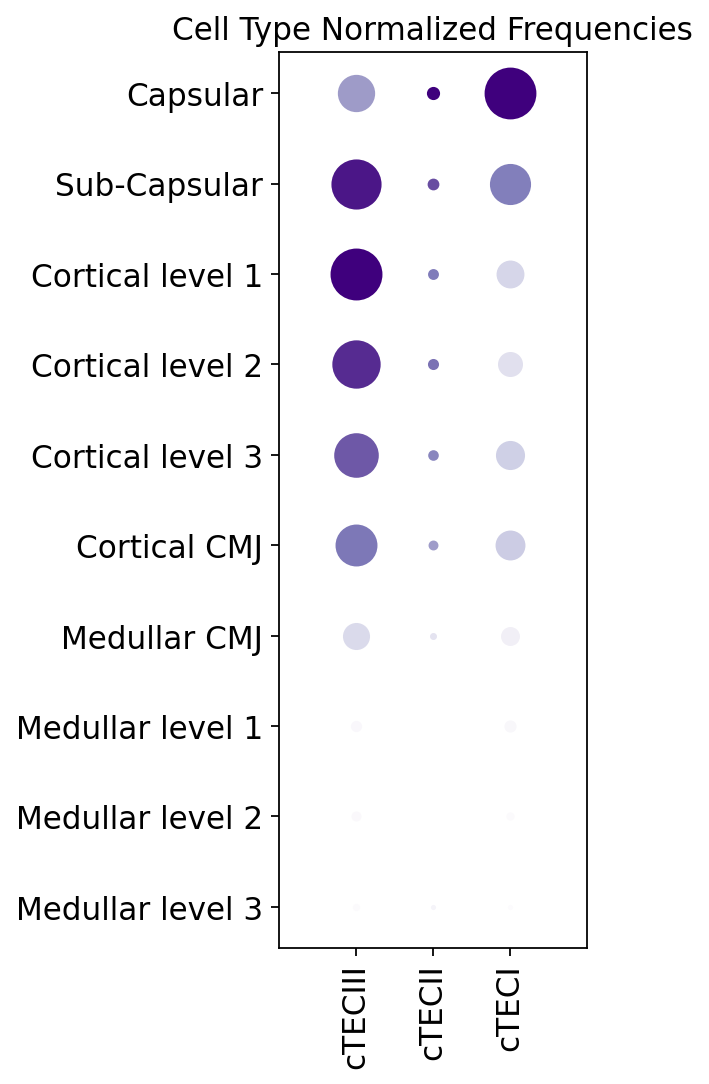

In [45]:
cells = ['cTECIII','cTECII','cTECI']
fraction = 0.45
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,
                  x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,
                  y_anno_groups = cells,figsize=[4,7],cmap='Purples') # save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/figures/cTECs_f'+str(fraction)+'_IBEX_impute.pdf')
plot_cell_dotplot2(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE',
                         x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,
                         export_path = f'{source_folder}/IBEX_paed_{fraction}_cTEC_dotplot.xlsx', figsize=[4,7],cmap='Purples')

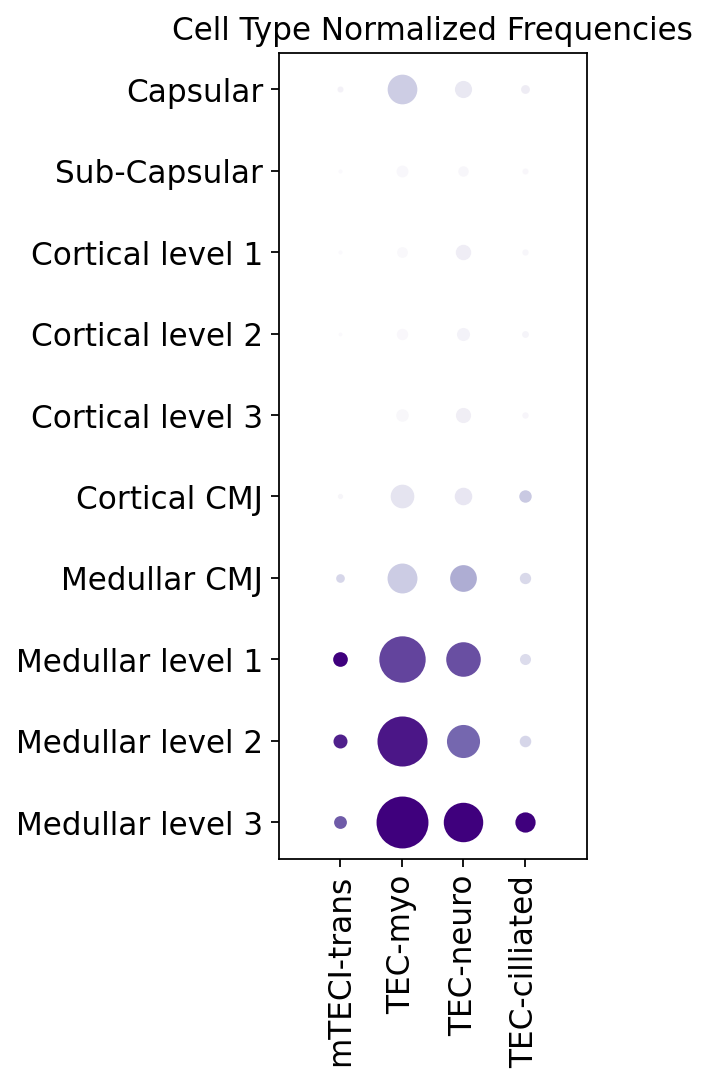

/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/IBEX_paed_0.3_TEC-mimetic_dotplot.xlsx has been written


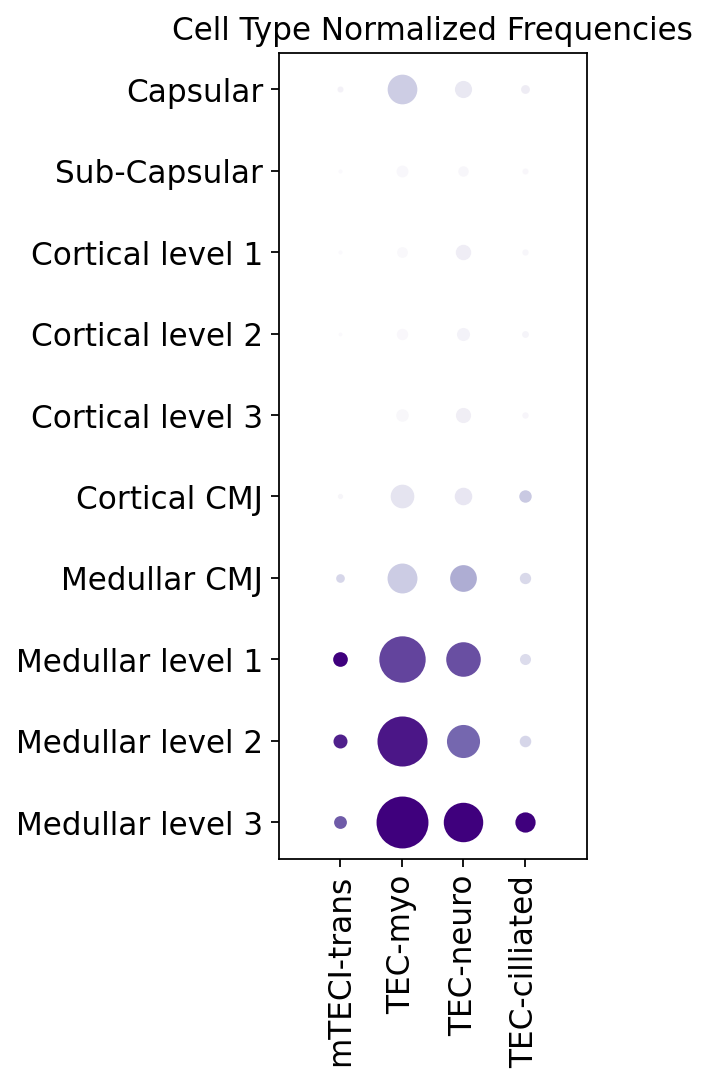

In [46]:
# special Tecs 
cells = ['mTECI-trans','TEC-myo','TEC-neuro','TEC-cilliated']
fraction = 0.3
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE', 
                  x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,
                  figsize=[4,7],cmap='Purples') #save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/figures/cTECs_special_f'+str(fraction)+'_IBEX_impute.pdf')
plot_cell_dotplot2(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE', 
                  x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,
                   export_path = f'{source_folder}/IBEX_paed_{fraction}_TEC-mimetic_dotplot.xlsx', figsize=[4,7],cmap='Purples') 

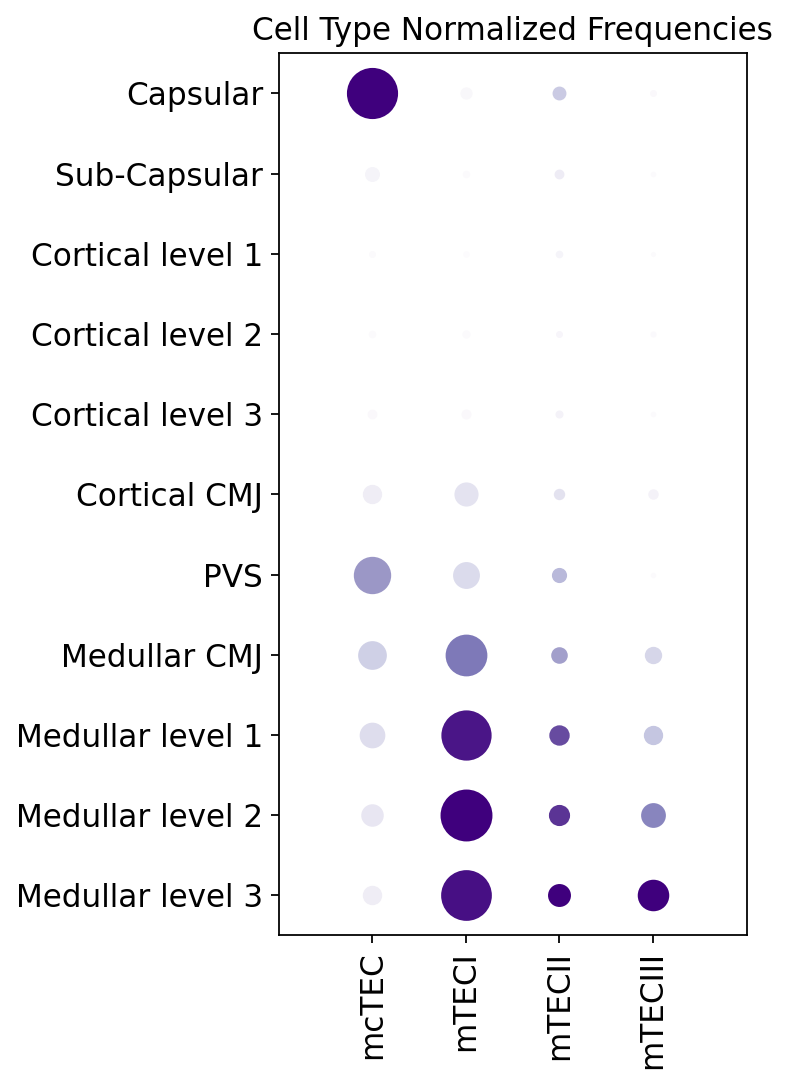

/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/IBEX_paed_0.85_mTEC-PVS_dotplot.xlsx has been written


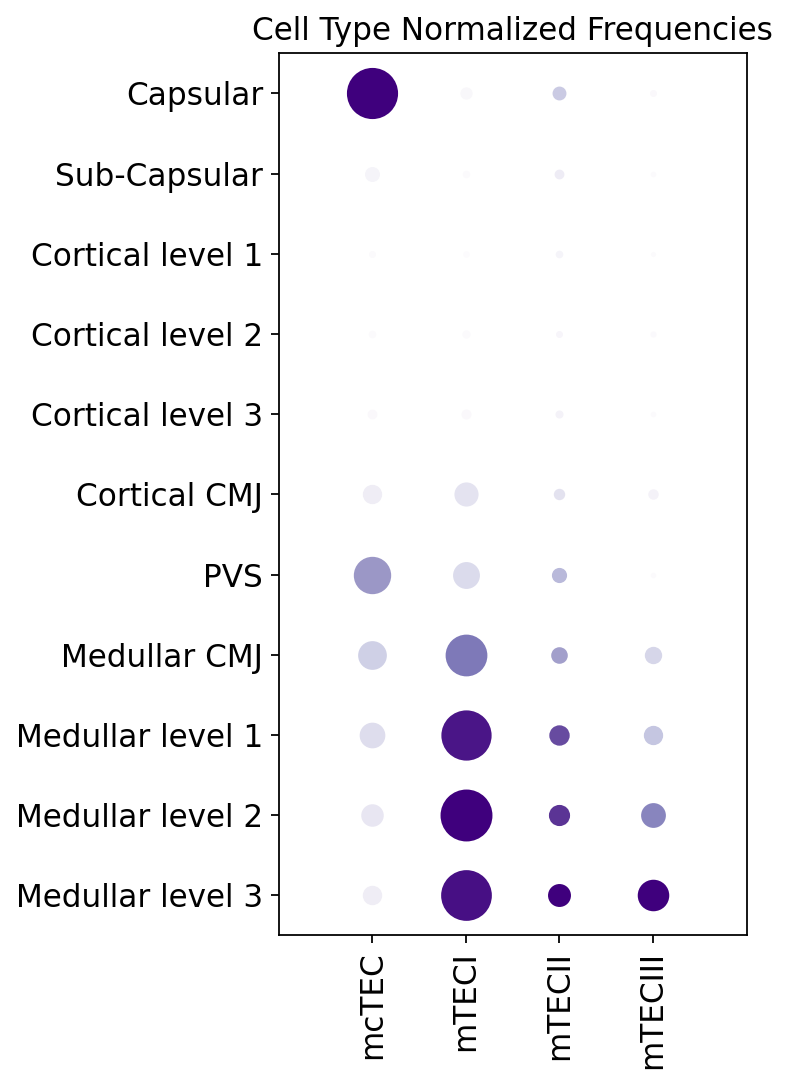

In [48]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/')
out.obs['manual_bin_cma_v2'] = out.obs['manual_bin_cma_v2'].astype('string')
out.obs.loc[out.obs['annotation_lv_1']=='PVS','manual_bin_cma_v2'] = 'PVS'
out.obs['manual_bin_cma_v2'] = out.obs['manual_bin_cma_v2'].astype('category')

ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','PVS','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
out.obs['manual_bin_cma_v2'] = out.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)

 
sc.set_figure_params(figsize=[5,5])
cells = ['mcTEC','mTECI','mTECII','mTECIII']
fraction = 0.85
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,
                  x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,
                  figsize=[5,7],cmap='Purples') # save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/figures/mTECs_PVS_f'+str(fraction)+'_IBEX_impute.pdf')
plot_cell_dotplot2(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,
                  x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,
                   export_path = f'{source_folder}/IBEX_paed_{fraction}_mTEC-PVS_dotplot.xlsx',
                   figsize=[5,7],cmap='Purples') 

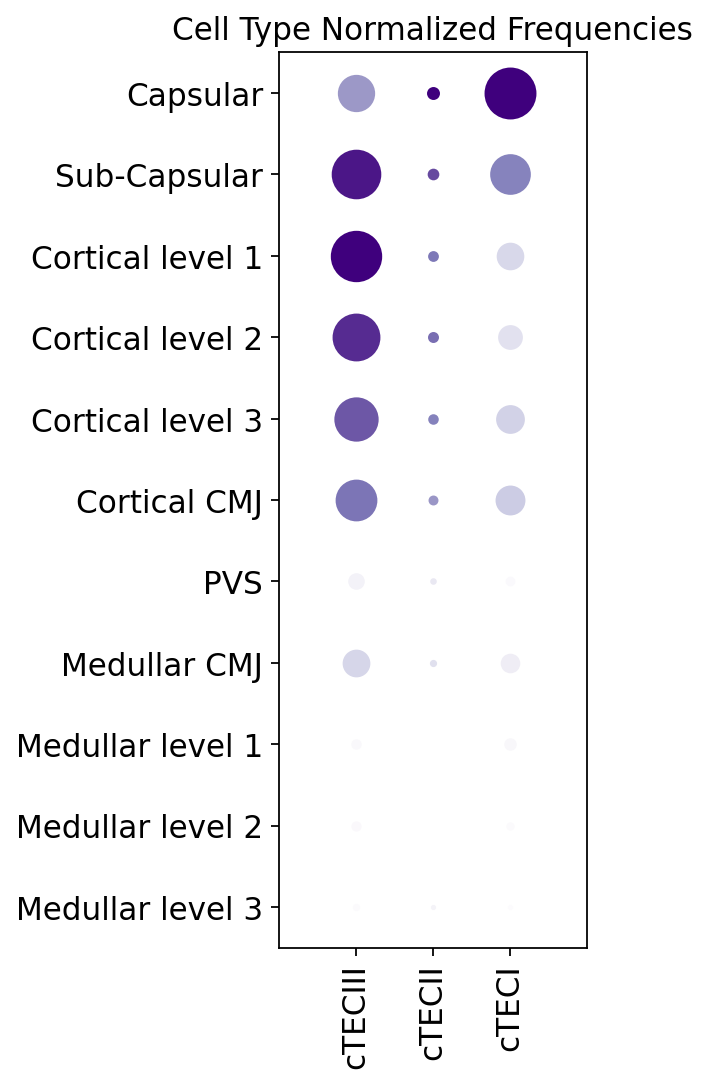

/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/IBEX_paed_0.45_cTEC-PVS_dotplot.xlsx has been written


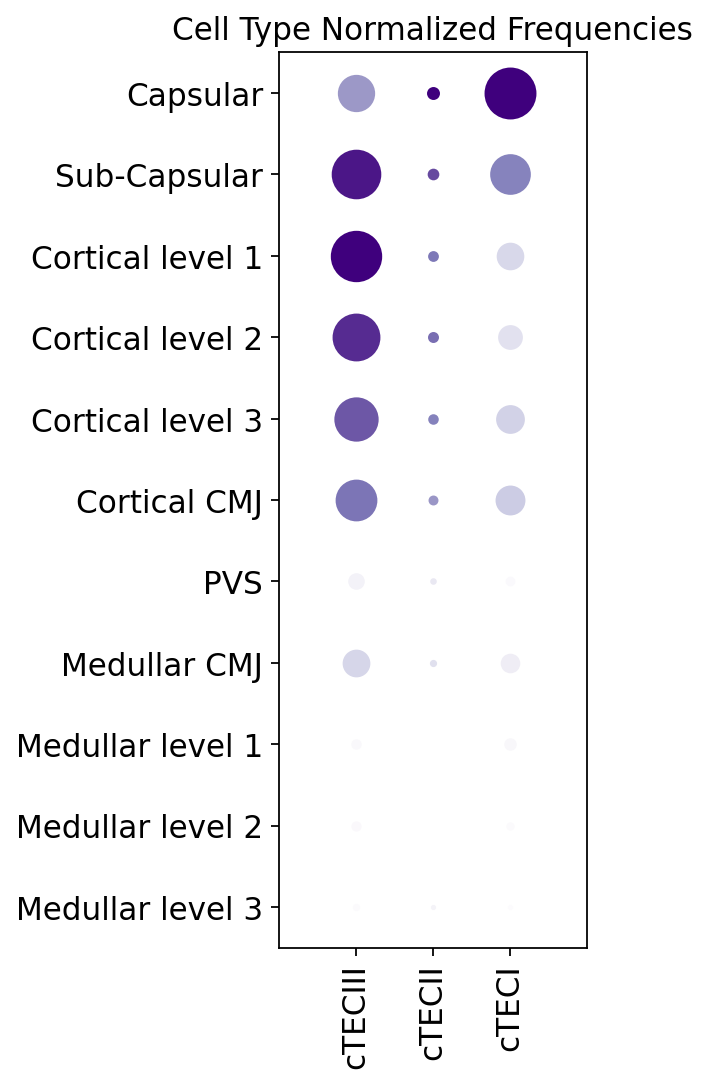

In [51]:
cells = ['cTECIII','cTECII','cTECI']
fraction = 0.45
plot_cell_dotplot(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,
                  x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,
                  figsize=[4,7],cmap='Purples') # save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/figures/cTECs_PVS_f'+str(fraction)+'_IBEX_impute.pdf')
plot_cell_dotplot2(out[out.obs['anno_CITE_fraction']>fraction], y_anno = 'anno_CITE' ,
                  x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,
                  export_path = f'{source_folder}/IBEX_paed_{fraction}_cTEC-PVS_dotplot.xlsx',
                  figsize=[4,7],cmap='Purples') 